# Training SAEs on Synthetic Data

This tutorial walks through how to train an SAE on synthetic data, sometimes called a toy model.

Training on synthetic data has a lot of advantages. We can control exactly what the "true features" are, and we can generate as much data as we want with any sort of correlation and geometry between features that we want. Plus, they're fast to run and can even work on CPU without issue. This makes it a great test-bed for new SAE architectures and training methods.

In this tutorial we'll go over how to create synthetic data, train an SAE on it, and evaluate the results. We'll also discuss how to make the toy setting more realistic by adding superposition noise, feature correlations, and feature hierarchy.

Most of the relevant functions for training on synthetic data can be found in the `sae_lens.synthetic` module.


## Initial setup


In [24]:
try:
    import google.colab  # type: ignore

    COLAB = True
    %pip install sae-lens kaleido
except:
    COLAB = False

## Creating a FeatureDictionary and ActivationsGenerator

To generate synthetic data, we need a set of "true feature", represented as a list of vectors, and a way to generate sparse feature activations from them. SAELens provides helper classes which do these two things:

1. **FeatureDictionary**: Maps sparse feature activations to dense hidden activations. Think of it as the "ground truth" dictionary that we want the SAE to recover.
2. **ActivationGenerator**: Generates sparse feature activations with controlled properties like firing probabilities, correlations, and hierarchies.

Let's start by creating a simple feature dictionary with 16 features embedded in a 32-dimensional space:


In [1]:
import torch
from sae_lens.synthetic import FeatureDictionary

# Configuration
num_features = 16  # Number of "true" features
hidden_dim = 32  # Dimension of the hidden space

# Create a feature dictionary
feature_dict = FeatureDictionary(
    num_features=num_features,
    hidden_dim=hidden_dim,
)

print(f"Feature dictionary shape: {feature_dict.feature_vectors.shape}")
print(
    f"Feature vectors are approximately orthogonal: "
    f"mean off-diagonal cos sim = {(feature_dict.feature_vectors @ feature_dict.feature_vectors.T).abs().fill_diagonal_(0).mean():.4f}"
)

Feature dictionary shape: torch.Size([16, 32])
Feature vectors are approximately orthogonal: mean off-diagonal cos sim = 0.0000


In [2]:
import plotly.express as px

from sae_lens.util import cosine_similarities

px.imshow(
    cosine_similarities(feature_dict.feature_vectors).detach(),
    zmin=-1,
    zmax=1,
    color_continuous_scale="rdbu",
    title="Cosine similarities between features in feature dictionary",
)

As we can see, the features are all perfectly orthogonal! By default the `FeatureDictionary` will try to make the features as orthogonal as possible. Since we have fewer features than dimensions here, the features are perfectly orthongal. This corresponds to no [superposition noise](https://transformer-circuits.pub/2022/toy_model/index.html).

Having no superposition noise is not very realistic, but it make it easy to see visually if an SAE we train is learning exactly the correct features or not. We'll see how to add superposition noise later in this tutorial.

You can also manually set or change `feature_dict.feature_vectors` if you want to impose a specific feature geometry on the features we're training on.


Now that we have a feature dictionary, we need to have a way to create activation firings for these features so that we can generate training data for our SAEs. Let's create an `ActivationGenerator` to manage that.

We'll need to set the number of features to match what we set in our `FeatureDictionary`. Then, we can control the firing probabilties for each of these features. We'll se each feature to fire 25% of the time. We'll also set each feature to fire with magnitude 1.0 and stdev 0.05.


In [3]:
from sae_lens.synthetic import ActivationGenerator

# Create an activation generator with uniform firing probabilities
firing_probs = (
    torch.ones(num_features) * 0.25
)  # 25% firing probability for each feature

activation_gen = ActivationGenerator(
    num_features=num_features,
    firing_probabilities=firing_probs,
    mean_firing_magnitudes=1.0,  # When a feature fires, it has magnitude ~1
    std_firing_magnitudes=0.05,  # With some variance
)

# Generate a batch of feature activations
feature_activations = activation_gen.sample(batch_size=1000)
print(f"Feature activations shape: {feature_activations.shape}")
print(
    f"Average L0 (features active per sample): {(feature_activations > 0).float().sum(dim=1).mean():.2f}"
)
print(f"Expected L0: {num_features * 0.25:.2f}")

# Convert to hidden activations using the feature dictionary
hidden_activations = feature_dict(feature_activations)
print(f"\nHidden activations shape: {hidden_activations.shape}")

Feature activations shape: torch.Size([1000, 16])
Average L0 (features active per sample): 3.98
Expected L0: 4.00

Hidden activations shape: torch.Size([1000, 32])


Let's look at a sample of feature activations to get a sense what they look like


In [4]:
feature_acts = activation_gen.sample(batch_size=1)

print(feature_acts)

tensor([[0.0000, 1.0373, 1.0699, 0.0000, 0.0000, 0.0000, 1.0138, 0.0000, 0.0000,
         0.0000, 0.0000, 0.9937, 1.0528, 0.0000, 1.0004, 0.9948]])


We see that most of the features have magnitude 0, meaning they're not firing. There are a few features that do fire, and their magnitude is near 1.0 as we'd expect. If you run this cell more times you'll see different random features firing and different magnitudes, but on average we expect 25% of the features to be active.

We can use these feature activations along with the `feature_dictionary` we created to generate training inputs for the SAE.


In [5]:
training_input = feature_dict(feature_acts)

print(f"training input shape: {training_input.shape}")

training input shape: torch.Size([1, 32])


These is just generate by multiplying the feature vectors in the `feature_dict` by the feature activations we generated and summing. You don't need to do this manually though - the `train_toy_sae()` helper will handle this for us as we'll see next!


## Training an SAE on Synthetic Data

Now let's train an SAE to recover the ground truth features. We'll use a standard SAE with ReLU activations and L1 regularization. We'll make our SAE have the same number of latents as we have true features. We also need to make sure the `d_in` of the SAE matches the `hidden_dim` that we set for the feature dictionary.

Then we'll use the `train_toy_sae()` helper to train the SAE. By default, this will train the SAE on 10M samples in batches of 1024, with learning rate 3e-4. These settings are fine for us, but you can customize them if you'd like.


In [6]:
from sae_lens import StandardTrainingSAE, StandardTrainingSAEConfig
from sae_lens.synthetic import train_toy_sae

# Create a standard SAE matching the feature dictionary dimensions
cfg = StandardTrainingSAEConfig(
    d_in=feature_dict.hidden_dim,
    d_sae=feature_dict.num_features,
    l1_coefficient=5e-2,
)
sae = StandardTrainingSAE(cfg)

# Train the SAE using the convenient train_toy_sae helper
train_toy_sae(
    sae=sae,
    feature_dict=feature_dict,
    activations_generator=activation_gen,
)

Training SAE:   0%|          | 0/10000000 [00:00<?, ?it/s]

10M samples may seem like a like, but it trains in under a minute even on CPU! This is one of the benefits of training toy SAEs on synthetic data - the iteration cycle is very fast, and doesn't need any expensive hardware.


## Visualizing SAE Feature Recovery

We can get a quick sense of what our SAE learned by plotting the cosine similarity of the SAE encoder and decoder with the feature vectors from our feature dictionary.

If all went well, our SAE should exactly learn one latet per dictionary feature, and each latent should have cosine similarity of 1.0 with the corresponding dictionary feature.


In [7]:
from sae_lens.synthetic import plot_sae_feature_similarity

# Plot cosine similarity between SAE features and true features
# reorder_features=True sorts SAE latents to best match true features for clearer visualization
plot_sae_feature_similarity(
    sae=sae,
    feature_dict=feature_dict,
    title="Cosine Similarity between SAE Encoder / Decoder and Feature Dictionary",
)

Hooray, that's exactly what we see! Our SAE has perfectly learned the features from our feature dictionary! However, the SAE latents are in a different order from the order in the feature dictionary, which makes it harder to visually understand. The order that the SAE learns features is random, so we can reorder the SAE latents to make the plot easier to understand.

The `plot_sae_feature_similarity` function has a parameter called `reorder_features` that you can set to `True` to make the feature ordering nicer.


In [8]:
plot_sae_feature_similarity(
    sae=sae,
    feature_dict=feature_dict,
    title="Cosine Similarity between SAE and Feature Dictionary, with nicer ordering",
    reorder_features=True,
)

That looks much better!


## Evaluating the Trained SAE

Now let's evaluate how well the SAE recovered the ground truth features. We'll use the `eval_sae_on_synthetic_data` function which computes several metrics:

- **MCC (Mean Correlation Coefficient)**: How well the SAE decoder aligns with the true features (1.0 = perfect). From the paper "[Compute Optimal Inference and Provable Amortisation Gap in Sparse Autoencoder](https://arxiv.org/abs/2411.13117)"
- **L0**: Average number of active SAE latents per sample
- **Dead latents**: How many SAE latents never activate
- **Shrinkage**: Ratio of output to input norm (1.0 = no shrinkage)


In [9]:
from sae_lens.synthetic import eval_sae_on_synthetic_data

# Evaluate the trained SAE
eval_result = eval_sae_on_synthetic_data(
    sae=sae,
    feature_dict=feature_dict,
    activations_generator=activation_gen,
    num_samples=100_000,
)

print("Evaluation Results:")
print(f"  MCC (higher is better, 1.0 = perfect): {eval_result.mcc:.4f}")
print(f"  True L0: {eval_result.true_l0:.2f}")
print(f"  SAE L0:  {eval_result.sae_l0:.2f}")
print(f"  Dead latents: {eval_result.dead_latents}")
print(f"  Shrinkage: {eval_result.shrinkage:.4f}")

Evaluation Results:
  MCC (higher is better, 1.0 = perfect): 1.0000
  True L0: 4.00
  SAE L0:  4.04
  Dead latents: 0
  Shrinkage: 0.9753


As expected from our plots, the SAE is basically perfect! The MCC score gives an automatic measure of how well the SAE learned the features in the feature dictionary.


## Realistic Firing Probabilities

So far, each feature fires with equal probability. In real neural networks, features typically follow a power-law (Zipfian) distribution where a few features fire frequently and most fire rarely. We can simulate this with the `zipfian_firing_probabilities` helper:


In [10]:
import plotly.express as px
import pandas as pd
from sae_lens.synthetic import zipfian_firing_probabilities

# Create Zipfian firing probabilities
zipf_probs = zipfian_firing_probabilities(
    num_features=num_features,
    exponent=1.0,  # Higher = steeper dropoff
    max_prob=0.3,  # Most frequent feature fires 30% of the time
    min_prob=0.01,  # Least frequent feature fires 1% of the time
)

# Create a DataFrame for plotting
df = pd.DataFrame(
    {
        "Feature Index": list(range(num_features)) * 2,
        "Firing Probability": list(zipf_probs.numpy()) + list(firing_probs.numpy()),
        "Distribution": ["Zipfian"] * num_features + ["Uniform"] * num_features,
    }
)

# Create side-by-side bar charts using plotly express
fig = px.bar(
    df,
    x="Feature Index",
    y="Firing Probability",
    facet_col="Distribution",
    color="Distribution",
    color_discrete_map={"Zipfian": "#636EFA", "Uniform": "#EF553B"},
    title="Firing Probability Distributions",
    height=400,
    width=800,
)
fig.update_layout(showlegend=False)
fig.show()

print(
    f"Zipfian: max={zipf_probs.max():.3f}, min={zipf_probs.min():.3f}, mean={zipf_probs.mean():.3f}"
)

Zipfian: max=0.300, min=0.010, mean=0.056


## Correlated Features

Real features often co-occur. For example, we'd expect that "cat" and "furry" features frequely fire together, but "cat" and "physicist" likely almost never fire together. We can add correlations between features by providing a `correlation_matrix` to the `ActivationGenerator`. You can make create correlation matrix manually, or you can use the `generate_random_correlation_matrix` helper if you'd just like some random correlations:


In [11]:
from sae_lens.synthetic import generate_random_correlation_matrix
import plotly.express as px

corr_matrix = generate_random_correlation_matrix(
    num_features=num_features,
)

# Create an activation generator with correlations
correlated_gen = ActivationGenerator(
    num_features=num_features,
    firing_probabilities=0.15,
    correlation_matrix=corr_matrix,
)

px.imshow(
    corr_matrix,
    title="Randomly generated correlation matrix",
    color_continuous_scale="rdbu",
    zmin=-1,
    zmax=1,
)

## Superposition Noise

We can create superposition noise by creating a feature dictionary with more features than hidden dimensions, so it's not possible to have them all be mutually orthongonal. By default, the `FeatureDictionary` will still try to make all the features as orthogonal as possible.


In [12]:
import plotly.express as px
from sae_lens.util import cosine_similarities

super_dict = FeatureDictionary(
    num_features=10,
    hidden_dim=8,
)

px.imshow(
    cosine_similarities(super_dict.feature_vectors).detach(),
    zmin=-1,
    zmax=1,
    color_continuous_scale="rdbu",
    title="Feature cosine similarities with superposition",
)

Another easy way to add some superposition noise that's less uniform is to remove the `inizializer` from the `FeatureDictionary`. The default initializer tries to orthogonalize the dictionary features as much as possible, but if no initializer is provided, the features will just be left at the random initialization, and these will likely be not completely orthogonal.


In [13]:
import plotly.express as px
from sae_lens.util import cosine_similarities

non_init_dict = FeatureDictionary(
    num_features=10,
    hidden_dim=20,
    initializer=None,
)

px.imshow(
    cosine_similarities(non_init_dict.feature_vectors).detach(),
    zmin=-1,
    zmax=1,
    color_continuous_scale="rdbu",
    title="Feature cosine similarities, no initializer",
)

With no initializer, even though there are more dimensions than the number of features, there is still significant superposition noise just from the random initialization of the features.


## Hierarchical Features

Features in real networks often have hierarchical relationships. For example, "golden retriever" is a child of "dog" which is a child of "animal". We can model this with `HierarchyNode`:

When a parent feature is inactive, all its children are also inactive. Children can also be marked as mutually exclusive (only one can fire at a time). This works by modifying the activation and disabling (setting to 0) the activations of child nodes if a parent node is not active (set to 0). This means it will reduce the firing frequencies of child nodes relative to what we set in `firing_probabilities`.


In [14]:
from sae_lens.synthetic import HierarchyNode, hierarchy_modifier, ActivationGenerator

# Create a hierarchy:
# Feature 0 (Animal) -> Feature 1 (Dog), Feature 2 (Cat) [mutually exclusive]
# Feature 1 (Dog) -> Feature 3 (Golden Retriever), Feature 4 (Poodle)

hierarchy = HierarchyNode(
    feature_index=0,  # "Animal"
    children=[
        HierarchyNode(
            feature_index=1,  # "Dog"
            children=[
                HierarchyNode(feature_index=3),  # "Golden Retriever"
                HierarchyNode(feature_index=4),  # "Poodle"
            ],
            mutually_exclusive_children=True,  # Can't be both breeds at once
        ),
        HierarchyNode(feature_index=2),  # "Cat"
    ],
    mutually_exclusive_children=True,  # Can't be both dog and cat
)

print("Hierarchy structure:")
print(hierarchy)

# Create activation generator with hierarchy
hierarchical_gen = ActivationGenerator(
    num_features=num_features,
    firing_probabilities=0.3,
    modify_activations=hierarchy_modifier([hierarchy]),
)

# Sample and check hierarchy constraints
h_samples = hierarchical_gen.sample(10000)

# When Animal (0) is off, Dog (1) and Cat (2) should also be off
animal_off = h_samples[:, 0] == 0
dog_when_animal_off = h_samples[animal_off, 1].sum()
cat_when_animal_off = h_samples[animal_off, 2].sum()
print(f"\nHierarchy validation:")
print(f"  When Animal is off: Dog fires {dog_when_animal_off:.0f} times (should be 0)")
print(f"  When Animal is off: Cat fires {cat_when_animal_off:.0f} times (should be 0)")

Hierarchy structure:
0x
    1x
        3 
        4 
    2 

Hierarchy validation:
  When Animal is off: Dog fires 0 times (should be 0)
  When Animal is off: Cat fires 0 times (should be 0)


Let's use this to create a [toy model of feature absorption](https://www.lesswrong.com/posts/kcg58WhRxFA9hv9vN/toy-models-of-feature-absorption-in-saes). We'll create a feature dictionary with 4 features, and set up a hierarchy between feature 0 (the parent) and feature 1 (the child), and train an SAE on it.


In [15]:
from sae_lens.synthetic import (
    FeatureDictionary,
    HierarchyNode,
    hierarchy_modifier,
    train_toy_sae,
    plot_sae_feature_similarity,
)
from sae_lens import StandardTrainingSAE, StandardTrainingSAEConfig

abs_feature_dict = FeatureDictionary(
    num_features=4,
    hidden_dim=10,
)

# set up hierarchy
child = HierarchyNode(1)  # feature 1 is the child
parent = HierarchyNode(0, children=[child])  # feature 0 is the parent

abs_activation_gen = ActivationGenerator(
    num_features=4,
    firing_probabilities=0.2,
    std_firing_magnitudes=0.01,
    modify_activations=hierarchy_modifier(parent),
)


# Create a standard SAE matching the feature dictionary dimensions
abs_sae = StandardTrainingSAE(
    StandardTrainingSAEConfig(
        d_in=abs_feature_dict.hidden_dim,
        d_sae=abs_feature_dict.num_features,
        l1_coefficient=5e-2,
    )
)

train_toy_sae(
    sae=abs_sae,
    feature_dict=abs_feature_dict,
    activations_generator=abs_activation_gen,
)

plot_sae_feature_similarity(
    abs_sae,
    abs_feature_dict,
    title="Feature recovery with hierarchy (f1 -> f0), showing feature absorption",
    reorder_features=True,
)

Training SAE:   0%|          | 0/10000000 [00:00<?, ?it/s]

Now we see that the SAE is engaging in feature absorption, where the encoder disables latent 0 when feature 1 is active, and the decoder for latent 1 mixes together both features 0 and 1.


## Putting It All Together: A More Challenging Synthetic Task

Let's create a more realistic synthetic task combining Zipfian probabilities and superposition (more features than dimensions):


In [16]:
# A more challenging setup: 32 features in 28 dimensions
challenge_num_features = 32
challenge_hidden_dim = 28

# Create feature dictionary (features will overlap due to superposition)
challenge_feature_dict = FeatureDictionary(
    num_features=challenge_num_features,
    hidden_dim=challenge_hidden_dim,
)

# Realistic Zipfian firing probabilities
challenge_probs = zipfian_firing_probabilities(
    num_features=challenge_num_features,
    exponent=1.2,
    max_prob=0.25,
    min_prob=0.01,
)

# Create a hierarchy: feature 0 is a parent with features 1-7 as children
# When feature 0 is inactive, all children will be deactivated
challenge_hierarchy = HierarchyNode(
    feature_index=0,
    children=[HierarchyNode(feature_index=i) for i in range(1, 8)],
)

# Create activation generator with hierarchy
challenge_gen = ActivationGenerator(
    num_features=challenge_num_features,
    firing_probabilities=challenge_probs,
    std_firing_magnitudes=0.3,
    modify_activations=hierarchy_modifier(challenge_hierarchy),
)

# Create a larger SAE
challenge_sae = StandardTrainingSAE(
    StandardTrainingSAEConfig(
        d_in=challenge_hidden_dim,
        d_sae=challenge_num_features,
        l1_coefficient=0.1,
    )
)

print(f"Challenge setup:")
print(f"  Features: {challenge_num_features}")
print(f"  Hidden dim: {challenge_hidden_dim}")
print(f"  Superposition ratio: {challenge_num_features / challenge_hidden_dim:.1f}x")
print(f"  Expected L0: {challenge_probs.sum():.2f}")
print(f"  Hierarchy: Feature 0 is parent of features 1-7")

Challenge setup:
  Features: 32
  Hidden dim: 28
  Superposition ratio: 1.1x
  Expected L0: 0.95
  Hierarchy: Feature 0 is parent of features 1-7


In [17]:
from sae_lens.synthetic import train_toy_sae, eval_sae_on_synthetic_data

# Train on the challenging task
train_toy_sae(
    sae=challenge_sae,
    feature_dict=challenge_feature_dict,
    activations_generator=challenge_gen,
)

# Evaluate
challenge_result = eval_sae_on_synthetic_data(
    sae=challenge_sae,
    feature_dict=challenge_feature_dict,
    activations_generator=challenge_gen,
)

print("\nChallenge Results:")
print(f"  MCC: {challenge_result.mcc:.4f}")
print(f"  True L0: {challenge_result.true_l0:.2f}")
print(f"  SAE L0: {challenge_result.sae_l0:.2f}")
print(f"  Dead latents: {challenge_result.dead_latents}")

Training SAE:   0%|          | 0/10000000 [00:00<?, ?it/s]


Challenge Results:
  MCC: 0.9881
  True L0: 0.68
  SAE L0: 1.74
  Dead latents: 0


In [18]:
# Visualize the challenge results
plot_sae_feature_similarity(
    sae=challenge_sae,
    feature_dict=challenge_feature_dict,
    title=f"Challenge: {challenge_num_features} Features in {challenge_hidden_dim} Dimensions",
    reorder_features=True,
    dtick=4,  # Tick every 4 features for readability
)

The SAE is clearly no longer perfect, but still not too bad! The superposition noise between features also makes the plot a bit harder to read.


## Advanced: custom activation modifiers

We used a hierarchy activation modifier above to enforce a hierarchical relationship between features. You can also define your own activation modifiers. All you need to provide is a function that takes in the feature activations and outputs modified feature activations.

For instance, we could implement the hierarchy from the feature absorption example above manually:


In [19]:
import torch
from sae_lens.synthetic import (
    FeatureDictionary,
    train_toy_sae,
    plot_sae_feature_similarity,
)
from sae_lens import StandardTrainingSAE, StandardTrainingSAEConfig

abs_feature_dict = FeatureDictionary(
    num_features=4,
    hidden_dim=10,
)


# set up hierarchy manually
def manual_hierarchy_fn(acts: torch.Tensor) -> torch.Tensor:
    feat_0_is_disabled = acts[:, 0] == 0
    acts[feat_0_is_disabled, 1] = 0
    return acts


abs_activation_gen = ActivationGenerator(
    num_features=4,
    firing_probabilities=0.2,
    std_firing_magnitudes=0.01,
    modify_activations=manual_hierarchy_fn,
)


# Create a standard SAE matching the feature dictionary dimensions
abs_sae = StandardTrainingSAE(
    StandardTrainingSAEConfig(
        d_in=abs_feature_dict.hidden_dim,
        d_sae=abs_feature_dict.num_features,
        l1_coefficient=5e-2,
    )
)

train_toy_sae(
    sae=abs_sae,
    feature_dict=abs_feature_dict,
    activations_generator=abs_activation_gen,
)

plot_sae_feature_similarity(
    abs_sae,
    abs_feature_dict,
    title="Manual feature hierarchy (f1 -> f0), showing feature absorption",
    reorder_features=True,
)

Training SAE:   0%|          | 0/10000000 [00:00<?, ?it/s]

## Advanced: Taking Snapshots During Training

If you want to see how an SAE changes during the course of training, you can set `n_shapshots` and provide a `snapshot_fn`, which takes in the SAE trainer and is called periodically thoughout training. Below, we'll use this to snapshot the SAE as it trains.


In [20]:
from copy import deepcopy
from sae_lens.synthetic import (
    FeatureDictionary,
    find_best_feature_ordering_across_saes,
    train_toy_sae,
    plot_sae_feature_similarity,
)
from sae_lens import StandardTrainingSAE, StandardTrainingSAEConfig

feature_dict = FeatureDictionary(
    num_features=4,
    hidden_dim=10,
)

activation_gen = ActivationGenerator(
    num_features=4,
    firing_probabilities=0.2,
    std_firing_magnitudes=0.01,
)


# Create a standard SAE matching the feature dictionary dimensions
sae = StandardTrainingSAE(
    StandardTrainingSAEConfig(
        d_in=feature_dict.hidden_dim,
        d_sae=feature_dict.num_features,
        l1_coefficient=5e-2,
    )
)

snapshots = []

train_toy_sae(
    sae=sae,
    feature_dict=feature_dict,
    activations_generator=activation_gen,
    n_snapshots=5,
    snapshot_fn=lambda trainer: snapshots.append(
        (trainer.n_training_steps, deepcopy(sae))
    ),
)

# find a consistent feature ordering for all snapshots
# we don't want different snapshot plots to be ordered differently
feature_ordering = find_best_feature_ordering_across_saes(
    [snap[1] for snap in snapshots], feature_dict
)

for train_step, snapshot_sae in snapshots:
    plot_sae_feature_similarity(
        snapshot_sae,
        feature_dict,
        title=f"Snapshot: train step {train_step}",
        reorder_features=feature_ordering,
        height=300,
        width=600,
    )

Training SAE:   0%|          | 0/10000000 [00:00<?, ?it/s]

## Bonus: Creating Training Animations

Looking at training snapshots can help us understand the training dynamics of the SAE, but wouldn't it be more fun to created a training animation instead? Let's use PIL to create an animated gif of SAE training! First, let's create some helper functions to merge some `.png` files into a GIF.

**NOTE**: This requires the `kaleido` package. Run `pip install kaleido` if you're mnissing it.


In [21]:
from pathlib import Path
import tempfile
from typing import Any
from PIL import Image

from sae_lens import SAE
from sae_lens.synthetic import (
    FeatureDictionary,
    find_best_feature_ordering_across_saes,
    plot_sae_feature_similarity,
)


def create_gif_animation(
    frame_files: list[Path] | list[str],
    output_path: str | Path,
    duration: float = 0.1,
    optimize: bool = True,
):
    """Create high-quality GIF animationn."""

    # Use PIL directly for better control over quantization
    images = []
    for frame_file in frame_files:
        img = Image.open(str(frame_file))
        if img.mode != "RGB":
            img = img.convert("RGB")
        images.append(img)

    if not images:
        return

    # Create GIF with better quantization settings
    first_frame = images[0]

    # Use a high-quality quantization method
    first_frame.save(
        str(output_path),
        save_all=True,
        append_images=images[1:],
        duration=int(duration * 1000),  # PIL expects milliseconds
        loop=0,
        optimize=optimize,
        # Let PIL choose the best quantization method
        # Using fewer colors but better algorithm for quality
    )


def _create_animation_frames(
    sae_frames: list[tuple[SAE[Any], str]],
    feature_dict: FeatureDictionary,
    frames_path: Path,
    height: int,
    width: int,
    show_values: bool,
    reorder_features: bool,
    dtick: int | None,
) -> list[Path]:
    frames_path.mkdir(parents=True, exist_ok=True)

    global_feature_ordering = False
    if reorder_features:
        best_ordering = find_best_feature_ordering_across_saes(
            [sae for sae, _ in sae_frames], feature_dict
        )
        global_feature_ordering = best_ordering

    frames = []
    for i, (sae, title_suffix) in enumerate(sae_frames):
        frame_path = frames_path / f"frame_{i:06d}.png"
        plot_sae_feature_similarity(
            sae=sae,
            feature_dict=feature_dict,
            title=title_suffix,
            height=height,
            width=width,
            show_values=show_values,
            reorder_features=global_feature_ordering,
            save_path=frame_path,
            show_plot=False,
            dtick=dtick,
        )
        frames.append(frame_path)
    return frames


def plot_sae_training_gif_animation(
    sae_frames: list[tuple[SAE[Any], str]],
    feature_dict: FeatureDictionary,
    save_path: str | Path,
    frames_path: Path | None = None,
    height: int = 400,
    width: int = 800,
    show_values: bool = False,
    reorder_features: bool = False,
    dtick: int | None = 1,
    duration: float = 0.1,
    optimize: bool = True,
):
    """Create high-quality animated GIF showing SAE training progression."""
    with tempfile.TemporaryDirectory() as temp_dir:
        frames_path = Path(temp_dir) if frames_path is None else frames_path
        frames = _create_animation_frames(
            sae_frames=sae_frames,
            feature_dict=feature_dict,
            frames_path=frames_path,
            height=height,
            width=width,
            show_values=show_values,
            reorder_features=reorder_features,
            dtick=dtick,
        )

        # Ensure output path has .gif extension
        output_path = Path(save_path)
        if output_path.suffix.lower() != ".gif":
            output_path = output_path.with_suffix(".gif")

        create_gif_animation(
            frames,
            output_path,
            duration=duration,
            optimize=optimize,
        )

Next, we'll train an SAE while taking lots of snapshots


In [22]:
from copy import deepcopy
from sae_lens.synthetic import FeatureDictionary, train_toy_sae, ActivationGenerator
from sae_lens import StandardTrainingSAE, StandardTrainingSAEConfig

feature_dict = FeatureDictionary(
    num_features=10,
    hidden_dim=20,
)

activation_gen = ActivationGenerator(
    num_features=feature_dict.num_features,
    firing_probabilities=0.2,
    std_firing_magnitudes=0.01,
)


# Create a standard SAE matching the feature dictionary dimensions
sae = StandardTrainingSAE(
    StandardTrainingSAEConfig(
        d_in=feature_dict.hidden_dim,
        d_sae=feature_dict.num_features,
        l1_coefficient=5e-2,
    )
)

snapshots = []

train_toy_sae(
    sae=sae,
    feature_dict=feature_dict,
    activations_generator=activation_gen,
    n_snapshots=20,
    snapshot_fn=lambda trainer: snapshots.append(
        (deepcopy(sae), f"Snapshot: train step {trainer.n_training_steps}")
    ),
)

plot_sae_feature_similarity(sae, feature_dict, reorder_features=True)

Training SAE:   0%|          | 0/10000000 [00:00<?, ?it/s]

And now, let's create the training animation


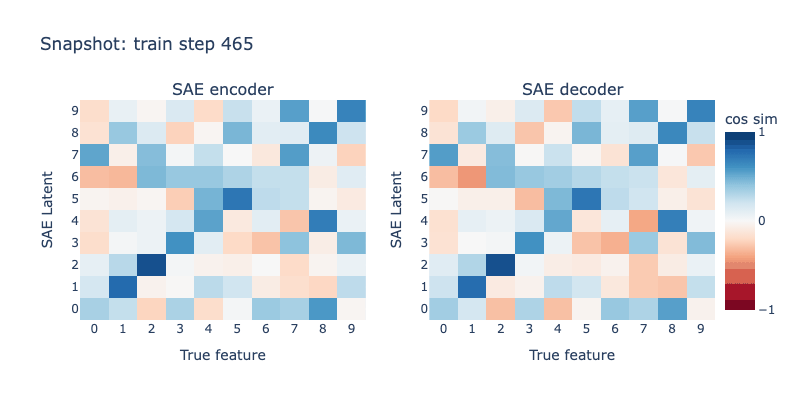

In [23]:
from IPython.display import display, Image as IPImage

output_path = "sae_training.gif"
plot_sae_training_gif_animation(
    snapshots, feature_dict, output_path, reorder_features=True
)
display(IPImage(filename=output_path))

Gradient descent is beautiful!


## Summary

In this tutorial, we covered:

1. **Basic Setup**: Creating `FeatureDictionary` and `ActivationGenerator` for synthetic data
2. **Training**: Using `train_toy_sae` to train an SAE on synthetic activations
3. **Evaluation**: Using `eval_sae_on_synthetic_data` to measure MCC and other metrics
4. **Visualization**: Using `plot_sae_feature_similarity` to visualize feature recovery
5. **Advanced Features**:
   - **Zipfian firing probabilities**: More realistic feature frequency distributions
   - **Correlated features**: Features that tend to co-occur or anti-occur
   - **Hierarchical features**: Parent-child relationships between features
6. **Training Animations**: Using snapshots and `plot_sae_training_gif_animation` to visualize how an SAE learns over time

The synthetic data framework is a great way to:

- Rapidly prototype new SAE architectures
- Understand failure modes before training on real data
- Create controlled experiments with known ground truth

## Happy Experimenting!
